In [41]:
import glob
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from astropy.io import fits
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader

In [42]:
import os
%env CUDA_LAUNCH_BLOCKING=1
print(os.environ['CUDA_LAUNCH_BLOCKING'])

env: CUDA_LAUNCH_BLOCKING=1
1


In [43]:
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device {device}")

Using device cuda


In [44]:
# Shuffle and split dataset
# Commenting this out for now, but we may want to reintroduce this at some point
# shuffler = np. random. permutation(len(X))
# X = torch.stack([X[i] for i in shuffler])
# y = torch.tensor([y[i] for i in shuffler])
# X_train = X[0:int(len(X) * 0.8)]
# X_test = X[int(len(X) * 0.8):]
# y_train = y[0:int(len(y) * 0.8)]
# y_test = y[int(len(y) * 0.8):]

In [45]:
from dataset import PlanetDataset

train_path = '../data/train'
test_path = '../data/test'
train_dataset = PlanetDataset(train_path, None, True, device, 1)
test_dataset = PlanetDataset(test_path, None, False, device)

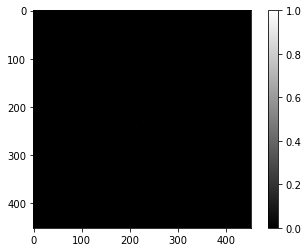

In [6]:
# Visualizing as sanity check
import matplotlib.pyplot as plt
from torchvision import transforms

# trans = transforms.Compose([transforms.ToTensor()])
demo_img = train_dataset[2][0]
# demo_img = trans(demo)
# print(demo_img.shape)
demo_array = np.moveaxis(demo_img.numpy()*255, 0, -1)
demo_img = torch.from_numpy(demo_array)
# print(demo_img.shape)


plt.figure()
plt.imshow(demo_img, cmap='gray')
plt.colorbar()
plt.show()

In [46]:
len(train_dataset.imgs)

1

In [47]:
def overlap(pred_box, true_box):
    # xmin, ymin, xmax, ymax
    true_center = ((true_box[0] + true_box[2]) / 2, (true_box[1] + true_box[3]) / 2)
    width_val = true_center[0] > pred_box[0] and true_center[0] < pred_box[2]
    height_val = true_center[1] > pred_box[1] and true_center[1] < pred_box[3]
    return width_val and height_val



def grade_boxes(pred_boxes, true_boxes):
    successes = 0
    for pred in pred_boxes:
        possibilities = 0
        for true in true_boxes:
            if overlap(pred, true):
                possibilities += 1
        if possibilities:
            successes += 1
    return successes

def check_accuracy(dataset, model, collate_fn):
    loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        counter = 0
        for imgs, targets in loader:
            for i in range(len(targets)):
                targets[i]['boxes'] = targets[i]['boxes'].to(device=device)
                targets[i]['labels'] = targets[i]['labels'].to(device=device)
                targets[i]['image_id'] = targets[i]['image_id'].to(device=device)
                targets[i]['area'] = targets[i]['area'].to(device=device)
                targets[i]['iscrowd'] = targets[i]['iscrowd'].to(device=device)
            imgs = imgs.to(device)
            predictions = model(imgs)
            
            print(f'Iter {counter}')
            pred_boxes = predictions[0]["boxes"]
            print(predictions)
            tg_boxes = targets[0]['boxes']
            
            if grade_boxes(pred_boxes, tg_boxes) > 0:
                num_correct += 1
            num_samples += 1
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [49]:
def train(model, optimizer, dataset, collate_fn, epochs=1):
    """
    Train a model PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(f'Beginning epoch {e + 1}')
        loss = None
        model.train()  # put model to training mode
        data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)
        counter = 0
        for imgs, targets in data_loader:
            
            for i in range(len(targets)):
                # print(len(targets[i]['boxes']) == len(targets[i]['labels']))
#                 print('boxes ', targets[i]['boxes'].shape)
#                 print('labels ', targets[i]['labels'].shape)
#                 print('image_id ', targets[i]['image_id'].shape)
#                 print('area ', targets[i]['area'].shape)
#                 print('iscrowd ', targets[i]['iscrowd'].shape)
#                 print('labels', targets[i]['labels'])
#                 print('boxes', targets[i]['boxes'])
#                 print('image_id', targets[i]['image_id'])
#                 print('area', targets[i]['area'])
#                 print('iscrowd', targets[i]['iscrowd'])
                targets[i]['boxes'] = targets[i]['boxes'].to(device=device)
                targets[i]['labels'] = targets[i]['labels'].to(device=device)
                targets[i]['image_id'] = targets[i]['image_id'].to(device=device)
                targets[i]['area'] = targets[i]['area'].to(device=device)
                targets[i]['iscrowd'] = targets[i]['iscrowd'].to(device=device)
            imgs = imgs.to(device)
#             print(imgs.device)
#             print(targets[0]['boxes'].device)
            images = list(image for image in imgs)
            targets = [{k: v for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            if not counter % 10: print(f'Iter {counter}: Loss = {loss}')
            counter += 1

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        print(f"Finished epoch (Loss: {loss})")

In [50]:
def collate_fn(batch):
    """
    Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

    :param batch: an iterable of N sets from __getitem__()
    :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
    """

    images = list()
    targets=list()

    for i, t in batch:
        images.append(i)
        targets.append(t)
    images = torch.stack(images, dim=0)

    return images, targets

In [51]:
# DEFINE THE PRETRAINED MODEL

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # 1 class (planet) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

In [52]:
learning_rate = 1e-4

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
train(model, optimizer, train_dataset, collate_fn, epochs=10)

Beginning epoch 1
Iter 0: Loss = 10.089599609375
Finished epoch (Loss: 10.089599609375)
Beginning epoch 2
Iter 0: Loss = 5.598808288574219
Finished epoch (Loss: 5.598808288574219)
Beginning epoch 3
Iter 0: Loss = 2.164825677871704
Finished epoch (Loss: 2.164825677871704)
Beginning epoch 4
Iter 0: Loss = 1.138843297958374
Finished epoch (Loss: 1.138843297958374)
Beginning epoch 5
Iter 0: Loss = 1.0245002508163452
Finished epoch (Loss: 1.0245002508163452)
Beginning epoch 6
Iter 0: Loss = 1.2163668870925903
Finished epoch (Loss: 1.2163668870925903)
Beginning epoch 7
Iter 0: Loss = 0.8618773221969604
Finished epoch (Loss: 0.8618773221969604)
Beginning epoch 8
Iter 0: Loss = 0.6757452487945557
Finished epoch (Loss: 0.6757452487945557)
Beginning epoch 9
Iter 0: Loss = 0.8405531048774719
Finished epoch (Loss: 0.8405531048774719)
Beginning epoch 10
Iter 0: Loss = 0.5224928259849548
Finished epoch (Loss: 0.5224928259849548)


In [54]:
check_accuracy(train_dataset, model, collate_fn)

Checking accuracy on validation set
Iter 0
[{'boxes': tensor([[223.7616, 211.8947, 225.9074, 213.8789],
        [223.8823, 211.3322, 225.6022, 212.9930],
        [225.7672, 211.7728, 227.7689, 213.7334],
        [221.9353, 211.9012, 223.9764, 213.9225],
        [225.8218, 211.0266, 227.5905, 212.7048],
        [222.2782, 210.5889, 223.8817, 212.2490]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0638, 0.0637, 0.0580, 0.0566, 0.0565, 0.0531], device='cuda:0')}]
Got 1 / 1 correct (100.00)


In [55]:
check_accuracy(test_dataset, model, collate_fn)

Checking accuracy on test set
Iter 0
[{'boxes': tensor([[ 75.4252, 391.2600,  76.6659, 392.7673],
        [ 74.1189, 389.8792,  75.3684, 391.2752],
        [ 73.3591, 391.2737,  74.7553, 392.7538],
        [ 75.2892, 389.7240,  76.4238, 391.1594],
        [ 75.3982, 389.6462,  77.1252, 391.5984],
        [ 77.2133, 391.2386,  78.3859, 392.6852],
        [ 73.6330, 389.0714,  75.2853, 390.9066],
        [ 77.3476, 391.2836,  79.2117, 393.1943]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0621, 0.0581, 0.0579, 0.0549, 0.0540, 0.0540, 0.0535, 0.0532],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 38.0236, 352.7174,  39.4299, 354.3691]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0508], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 41.8877, 327.8250,  43.0006, 329.1591],
        [ 41.4773, 334.4109,  42.9953, 335.8794],
        [ 41.7159, 335.6826,  43.0607, 337.1730],
        [ 41.7503, 327

Iter 0
[{'boxes': tensor([[ 41.1674, 355.4401,  42.7803, 357.1437],
        [ 41.1621, 353.4428,  42.5590, 354.9850]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0501, 0.0501], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 38.9005, 334.4380,  40.3422, 335.8388],
        [ 37.0856, 334.9286,  38.5414, 336.4609],
        [ 36.1475, 336.4352,  37.3268, 337.6670],
        [ 76.1217, 391.3511,  77.3413, 392.9185],
        [ 74.1372, 391.1700,  75.4796, 392.7999],
        [ 37.4969, 334.0946,  38.6245, 335.3526]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0533, 0.0530, 0.0518, 0.0516, 0.0510, 0.0502], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 39.8990, 343.0793,  41.1322, 344.7530],
        [ 37.6723, 343.1587,  38.9660, 344.9133]], device='cud

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 42.6098, 347.2840,  44.1594, 348.8461],
        [ 39.1582, 338.8561,  40.4324, 340.3919],
        [ 39.3249, 338.4886,  40.3680, 339.6682],
        [ 37.3232, 338.0518,  38.4072, 339.2495],
        [ 39.7241, 340.4726,  40.8291, 341.6704],
        [ 37.6385, 340.1291,  38.8094, 341.3062]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0543, 0.0521, 0.0513, 0.0511, 0.0508, 0.0506], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 40.6241, 334.0330,  42.1175, 335.8924],
        [ 40.9603, 335.0132,  42.1799, 336.4915],
        [ 39.7683, 336.5677,  41.0759, 338.1118],
        [ 40.7267, 336.0194,  42.2155, 337.9333],
        [ 39.5377, 333.0543,  40.7799, 334.5195],
        [ 38.7275, 334.4947,  40.3460, 336.5204],
        [ 34.4860, 330.5691,  36.4761, 332.729

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 84.4140, 389.0012,  85.8523, 390.4696],
        [ 82.9856, 388.7292,  84.4526, 390.3363]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0550, 0.0511], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 76.5593, 377.4990,  78.1816, 378.9785],
        [ 77.2270, 377.3293,  79.3006, 379.4653],
        [ 76.5561, 379.8387,  78.2491, 381.4197],
        [ 75.5154, 379.2747,  77.5484, 381.4227],
        [ 77.4199, 379.1247,  79.5450, 381.2986],
        [ 77.1727, 375.7

Iter 0
[{'boxes': tensor([[ 53.3887, 373.2127,  55.1683, 375.3363]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0548], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[386.3730,  66.5207, 388.1670,  67.9693],
        [ 77.5089, 392.5800,  79.0178, 394.5806],
        [ 77.6932, 392.0075,  79.9020, 394.4267],
        [ 75.8767, 391.7943,  78.1061, 394.2224],
        [ 76.0001, 392.7312,  77.6240, 394.8564],
        [ 41.7604, 352.8563,  43.0769, 354.5570],
        [ 75.9435, 391.5717,  77.4650, 393.4474],
        [ 73.8928, 391.5970,  75.5848, 393.4879],
        [ 77.7491, 391.5573,  79.1238, 393.3796],
        [ 79.0849, 392.2054,  81.1887, 394.6622],
        [ 72.9673, 389.6751,  75.1639, 392.0217],
        [ 71.7808, 389.2328,  73.6067, 391.1877],
        [ 74.4557, 392.9102,  76.1729, 395.0424],
 

Iter 0
[{'boxes': tensor([[ 39.5794, 351.1273,  40.7327, 352.5968],
        [185.7308, 220.2457, 187.0483, 221.8464],
        [209.5644, 252.5710, 242.5965, 262.6106],
        [253.6431, 193.4371, 255.0238, 195.0222],
        [ 41.0257, 351.8538,  42.6847, 353.7674]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0513, 0.0510, 0.0506, 0.0503, 0.0502], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 36.8199, 348.2451,  38.1934, 349.9716],
        [ 37.8639, 350.6533,  39.3052, 352.4399],
        [ 76.9076, 392.1510,  78.5065, 394.0331],
        [ 77.1097, 392.3093,  79.4554, 394.3697],
        [ 42.1880, 350.8423,  43.5568, 352.5821],
        [ 37.0317, 351.2539,  38.4427, 353.0391],
        [ 39.9483, 350.6550,  41.3276, 352.3353],
        [ 44.6884, 350.6915,  46.0956, 352.4931],
        [ 75.1253, 392.1280,  77.3385, 394.0367],
        [ 38.9468, 347.8831,  40.3413, 349.6784],
        [ 37.4749, 345.5746,  38.8196, 347.3187],
        [ 75.52

Iter 0
[{'boxes': tensor([[ 38.1824, 340.9689,  39.7439, 342.9774],
        [386.0876,  66.8051, 387.7199,  68.3134],
        [ 36.8757, 340.8253,  38.4603, 342.8647],
        [222.0478, 212.3047, 223.8362, 214.0522],
        [ 35.9254, 338.8838,  37.4185, 340.8566],
        [ 40.2538, 333.4218,  41.6882, 335.1732],
        [ 37.8936, 342.7807,  39.5012, 344.7721],
        [ 37.2307, 338.6084,  38.6732, 340.4303],
        [ 35.2714, 340.6787,  36.9575, 342.6697],
        [ 40.3223, 340.9208,  41.7422, 342.8743],
        [378.8671,  61.2322, 380.4200,  63.0917]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0566, 0.0565, 0.0565, 0.0531, 0.0528, 0.0525, 0.0524, 0.0521, 0.0518,
        0.0507, 0.0501], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[363.3472,  45.5217, 365.

Iter 0
[{'boxes': tensor([[233.2456, 207.5304, 235.0570, 209.1707],
        [233.8194, 209.1259, 235.8321, 210.9219]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0522, 0.0507], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 39.3789, 338.9370,  40.4621, 340.1909],
        [ 37.2489, 339.0293,  38.3574, 340.2493],
        [ 37.2918, 340.8741,  38.4644, 341.9942],
        [ 36.6865, 339.1884,  37.7537, 340.4128],
        [ 35.6568, 339.5419,  36.7595, 340.7603],
        [ 75.2457, 382.7355,  76.6859, 384.2234],
        [ 75.0869, 382.6977,  76.2117, 383.8691],
        [ 37.9097, 337.1460,  38.9431, 338.4445],
        [ 36.9675, 337.1024,  38.0066, 338.4019],
        [ 39.8928, 337.1815,  40.9257, 338.5214],
        [ 93.6759, 392.6031,  95.3319, 393.9537]], device='cuda:0'), 'labels': tensor([1, 

Iter 0
[{'boxes': tensor([[ 77.0933, 392.0297,  79.1028, 393.8154],
        [ 75.0375, 391.3415,  77.1183, 393.0857],
        [ 76.7743, 392.6628,  78.2186, 394.4216],
        [ 73.7267, 390.3372,  75.7444, 391.9981],
        [ 75.1880, 390.9300,  76.7060, 392.5811],
        [ 73.4494, 391.0620,  75.5152, 392.8026],
        [ 78.6411, 391.4159,  80.3717, 393.3021],
        [ 57.6544, 366.5860,  58.8017, 368.0145],
        [ 76.3047, 390.7089,  77.7248, 392.2481],
        [ 77.0117, 390.8921,  78.9906, 392.8901],
        [ 73.7696, 389.3745,  75.3770, 391.0468],
        [ 56.8438, 366.8377,  58.3872, 368.4970],
        [ 73.8684, 388.7135,  75.8324, 390.8859],
        [ 74.8732, 389.7834,  76.2589, 391.2521],
        [ 74.3442, 387.8120,  75.6556, 389.1997],
        [ 79.5321, 390.2665,  80.8164, 391.7678],
        [ 57.1461, 368.3931,  58.9358, 370.1955],
        [ 75.2944, 389.4432,  77.3160, 391.6590]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Iter 0
[{'boxes': tensor([[ 36.0354, 337.4631,  37.6588, 339.6380],
        [ 36.1021, 335.2613,  37.6889, 337.1593],
        [ 38.0506, 336.5365,  39.2642, 338.0071],
        [ 38.3222, 337.2362,  39.8335, 339.1507],
        [ 38.2600, 338.6723,  39.4990, 340.2157],
        [ 36.3184, 332.6449,  37.8102, 334.3918]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0601, 0.0575, 0.0535, 0.0533, 0.0519, 0.0513], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 75.5648, 384.2896,  77.0578, 385.7547],
        [ 75.9564, 385.2077,  76.9535, 386.2329],
        [ 75.4490, 386.7179,  77.0257, 388.2793],
        [ 76.5629, 383.9476,  77.9359, 385.2869],
        [ 74.9507, 387.2566,  76.0569, 388.3582],
        [ 75.8275, 382.4523,  77.2755, 383.8598],
        [ 73.6031, 388.3643,  75.4589, 390.0928],
        [ 74.2777, 387.5431,  75.5141, 388.7608],
        [ 37.9294, 338.3376,  39.0485, 339.5002],
        [ 73.9484, 386.6769,  75.5622, 388.4337],
    

Iter 0
[{'boxes': tensor([[ 60.1631, 374.8837,  61.6608, 376.9926],
        [ 59.9027, 374.0847,  62.0816, 376.6093],
        [220.8852, 207.4785, 222.7063, 209.0450],
        [ 58.0199, 375.1474,  59.6296, 377.1521]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0521, 0.0517, 0.0506, 0.0500], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 79.1626, 373.0545,  81.4426, 375.2563],
        [ 78.0546, 373.4722,  80.3023, 375.6786],
        [ 81.4041, 373.6862,  83.0096, 375.3392],
  

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[363.6956,  45.3416, 365.6468,  47.2203],
        [362.0930,  45.1100, 364.0531,  46.9200],
        [ 63.7188, 362.8696,  65.2115, 364.6383],
        [ 53.7261, 373.2948,  55.2405, 375.2419],
        [ 62.0279, 361.7508,  63.0929, 363.2524],
        [ 53.8783, 371.0609,  55.4128, 372.9577],
        [ 63.8818, 363.7985,  64.9343, 365.2568],
        [ 77.1592, 392.5479,  78.5639, 394.5583],
        [ 75.7450, 392.6183,  77.2538, 394.7221]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0640, 0.0620, 0.0549, 0.0543, 0.0521, 0.0521, 0.0515, 0.0509, 0.0506],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 36.4222, 336.6575,  37.5785, 337.9361]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0600], device='cuda:0')}]
I

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 39.3768, 326.1797,  40.9144, 328.0569],
        [ 59.9423, 374.7270,  61.5135, 376.7849]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0515, 0.0514], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 38.8357, 350.7517,  40.3288, 352.5287],
        [ 37.3144, 351.0052,  38.8179, 352.8455],
        [ 40.0669, 350.9715,  41.4964, 352.6148],
        [376.6886,  59.2409, 378.7902,  60.9456],
        [ 38.8209, 348.2936,  40.3261, 350.0600],
        [ 41.9158, 351.0842,  43.3154, 352.7387],
        [ 61.0144, 374.2217,  63.2991, 376.7721],
        [ 59.8604, 374.1530,  62.1660, 376.7599],
        [ 61.6315, 374.8816,  63.0971, 377.0636]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0547, 0.0546, 0.0540, 0.0530, 0.0522,

Iter 0
[{'boxes': tensor([[ 56.5716, 363.0901,  57.9743, 365.0251],
        [ 59.4980, 362.7171,  60.8675, 364.5185],
        [ 54.5867, 362.8489,  56.2359, 365.0399],
        [ 56.9693, 361.7541,  58.2358, 363.3653]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0530, 0.0508, 0.0506, 0.0503], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[362.3569,  45.2161, 364.3417,  46.9264],
        [377.1203,  59.3792, 378.9310,  61.2326],
        [376.4232,  59.1818, 378.1517,  60.7780],
        [378.6954,  61.3659, 380.2914,  63.3702]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0617, 0.0559, 0.0551, 0.0509], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 71.5141, 387.6385,  73.2107, 389.1962],
        [ 72.1915, 387.9328,  73.3640, 389.4052],
        [ 71

Iter 0
[{'boxes': tensor([[ 53.0916, 370.9150,  54.8283, 372.8810]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0520], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 90.2954, 405.0562,  91.9477, 407.0189]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0503], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 72.9642, 388.3989,  74.8828, 390.2986],
        [ 74.0615, 389.0672,  75.5562, 390.4276],
        [ 73.7850, 389.5753,  75.7456, 391.0510],
        [ 73.4389, 389.9629,  75.3686, 391.3944],
        [ 74.4789, 388.8564,  75.7623, 390.1441],
        [ 73.0569, 387.3711,  75.0274, 389.1269],
        [ 73.1637, 390.7882,  74.7099, 392.3136],
        [ 75.1739, 390.7325,  76.5487, 392.2432],
        [ 75.2381, 389.4439,  77.2785, 391.2041],
        [ 71.1303, 387.3732,

Iter 0
[{'boxes': tensor([[ 37.0896, 350.5897,  38.6833, 352.5944]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0516], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 33.2243, 333.0084,  35.1023, 334.5929],
        [ 29.8115, 330.2242,  31.7540, 331.7562],
        [ 70.7423, 387.6470,  73.0164, 389.4223]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0546, 0.0523, 0.0504], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 36.6680, 338.6002,  37.8666, 339.8345],
        [ 36.8531, 337.8055,  38.2246, 339.4851],
        [ 34.0225, 337.3033,  35.6770, 339.0719],
        [ 36.5503, 336.7072,  37.7058, 338.0026],
        [ 39.6217, 335.2816,  40.8203, 336.8018],
        [ 41.5425, 337.5925,  42.8407, 339.1831]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0641, 0.0612, 0.0560, 0.0558, 0.0511, 0.0505], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 41.5287, 352.8332,  42.944

Iter 0
[{'boxes': tensor([[ 74.6871, 391.2709,  76.3851, 393.1286],
        [ 75.2282, 390.9787,  77.4785, 393.3663],
        [ 76.0860, 391.0984,  77.6601, 392.9778],
        [ 73.8642, 391.2430,  75.6123, 393.0975],
        [ 77.4449, 391.4484,  79.6508, 393.9010],
        [ 51.3117, 366.7255,  53.1497, 368.7364],
        [ 75.8438, 393.0178,  77.5543, 395.1534]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0523, 0.0518, 0.0512, 0.0505, 0.0503, 0.0502, 0.0501],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[397.0286,  80.4712, 398.7169,  82.2783],
        [396.6856,  80.0277, 398.4643,  81.9332],
        [396.1049,  79.7283, 397.7579,  81.4166],
        [ 41.7504, 354.7812,  43.3289, 356.7661],
        [383.7974,  63.6858, 385.7620,  65.4829],
        [377.5462,  58.8420,

Iter 0
[{'boxes': tensor([[ 55.5708, 369.9672,  57.7172, 372.1819],
        [ 57.6222, 370.1117,  59.4309, 372.2636],
        [ 58.3064, 370.3630,  59.9540, 372.3545],
        [ 60.7387, 371.6726,  62.4950, 373.8529],
        [ 55.4382, 368.9568,  56.7935, 370.5468],
        [ 63.5094, 371.8737,  65.1009, 373.8453],
        [ 56.5791, 368.8628,  57.8288, 370.4225],
        [ 61.0239, 370.8427,  62.2284, 372.3591],
        [ 59.9587, 370.6594,  61.4563, 372.5468],
        [ 61.9126, 372.7240,  63.2616, 374.3398],
        [ 58.6108, 371.1069,  59.9201, 372.6803],
        [ 65.8924, 371.9117,  67.4030, 373.6518],
        [ 58.9497, 371.2576,  60.8939, 373.5701],
        [ 56.3642, 371.1959,  57.7803, 372.7869],
        [ 63.7626, 370.9936,  65.1476, 372.7187],
        [ 60.0243, 372.8812,  61.4465, 374.5710],
        [ 56.1054, 368.2700,  57.9792, 370.4840],
        [ 63.0340, 370.4834,  64.1836, 371.9682],
        [ 53.0115, 368.8136,  54.4820, 370.4967],
        [ 55.0515, 371.1577,  56

Iter 0
[{'boxes': tensor([[401.7730,  81.7754, 403.5058,  83.5582],
        [ 61.1579, 369.2542,  62.4743, 370.8301],
        [398.1566,  79.2026, 399.7570,  80.8425],
        [ 61.2471, 368.4338,  62.8951, 370.4904],
        [400.8371,  81.4370, 402.5307,  83.0967]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0546, 0.0524, 0.0520, 0.0515, 0.0510], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 37.1482, 348.3717,  38.5450, 350.3370],
        [ 37.9214, 346.3389,  39.2834, 348.2780],
        [ 42.3585, 352.9052,  43.7130, 354.6643],
        [ 38.5703, 350.1550,  39.9820, 352.1783],
        [ 39.5086, 348.3023,  40.8837, 350.2989],
        [ 42.4269, 354.6246,  43.9550, 356.5387],
        [ 37.4857, 350.4344,  38.9125, 352.3890],
        [ 40.2915, 350.5172,  41.6164, 352.3418],
        [ 40.5613, 352.4612,  41.9886, 354.3380],
        [ 42.3765, 350.8701,  43.6096, 352.5968]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Iter 0
[{'boxes': tensor([[ 37.3100, 348.1321,  38.5366, 349.6063],
        [ 39.5568, 348.0878,  40.7179, 349.5157],
        [ 57.9609, 372.7227,  59.5248, 374.5048],
        [ 72.6342, 382.2354,  73.9314, 383.6339],
        [ 71.5183, 382.5726,  72.9688, 384.0309],
        [ 74.5088, 382.0518,  75.6554, 383.3925],
        [ 56.3155, 370.9761,  57.8456, 372.6431],
        [ 56.2700, 369.3083,  57.6811, 370.9129],
        [ 84.6331, 384.2316,  86.1240, 385.6634],
        [ 71.1478, 383.1928,  72.9716, 385.0378],
        [ 55.6236, 370.8655,  57.1913, 372.6922]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0579, 0.0562, 0.0527, 0.0523, 0.0521, 0.0520, 0.0512, 0.0511, 0.0511,
        0.0508, 0.0508], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 75.7152, 392.5970,  77.

Iter 0
[{'boxes': tensor([[169.3741, 210.7733, 179.0958, 236.2001],
        [172.9223, 211.1875, 183.2789, 236.2765],
        [171.5004, 251.9449, 173.6723, 254.7031],
        [171.1503, 250.1314, 173.4190, 252.9182],
        [171.1131, 246.2594, 172.8316, 248.1459],
        [169.9212, 217.0040, 171.6873, 218.9918],
        [170.7938, 251.3851, 172.5536, 253.5802],
        [173.4930, 225.3821, 183.4890, 249.4151],
        [168.0470, 217.1162, 169.6509, 218.9684],
        [171.1830, 253.0481, 172.9013, 255.2423],
        [174.6565, 257.9022, 176.6014, 260.1287],
        [176.7821, 259.0699, 179.0299, 261.5259],
        [170.8387, 244.2489, 172.7769, 246.4485],
        [168.3442, 215.0317, 170.0101, 216.9898],
        [170.2504, 241.9673, 171.8614, 243.9184],
        [167.7610, 218.9748, 169.3389, 220.8183],
        [170.1150, 232.8755, 171.6914, 235.0211],
        [172.1632, 255.6910, 173.9945, 257.8888],
        [169.7537, 221.4262, 171.4966, 223.4550],
        [170.1752, 249.9209, 172

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 38.2776, 336.5847,  39.3713, 337.7672]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0509], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 38.9874, 334.6137,  40.0770, 335.8850],
        [ 78.5413, 379.3610,  79.9575, 380.9341],
        [ 39.0378, 334.0105,  40.4461, 335.5429],
        [ 40.4639, 350.7806,  41.7364, 352.2883],
        [ 36.6611, 334.8399,  37.8118, 336.1364]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0520, 0.0518, 0.0516, 0.0511, 0.0509], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 74.2456, 391.0615,  76.0102, 393.0167],
        [ 75.3046, 391.1295,  76.9328, 393.0408],
        [ 35.6597, 326.8877,  37.4480, 328.7051],
        [ 56.3442, 374.4901,  58.1596, 376.7455],
        [ 76.9756, 390.9299,  78.5

Iter 0
[{'boxes': tensor([[ 75.9873, 387.0703,  77.6396, 388.8468],
        [ 53.3634, 369.1191,  54.7340, 370.7713],
        [ 74.0280, 388.6775,  76.0168, 390.7779],
        [ 53.0582, 367.9446,  54.9541, 369.9792],
        [ 75.1448, 388.9286,  77.1892, 390.9322],
        [ 75.8368, 388.7269,  77.5525, 390.5348],
        [ 73.9676, 387.6924,  75.2402, 389.1287],
        [ 73.4908, 389.1393,  75.0859, 390.7359],
        [ 74.1400, 389.2954,  75.5368, 390.7513],
        [ 38.9803, 350.2923,  40.2336, 351.7866],
        [ 55.7759, 371.0581,  57.2667, 372.7728],
        [ 74.2686, 386.8168,  76.1310, 388.9377]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0549, 0.0542, 0.0528, 0.0522, 0.0521, 0.0519, 0.0518, 0.0517, 0.0517,
        0.0506, 0.0501, 0.0500], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 45.0589, 354.8227,  46.2664, 356.5702],
        [ 79.3200, 389.4473,  80.8420, 391.3026],
        [ 43.4021, 354.6726,  

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[131.8359, 427.8837, 133.5567, 429.5809],
        [133.2628, 428.0235, 135.0844, 429.7549]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0526, 0.0506], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 71.6203, 389.3428,  73.3344, 391.2614],
        [ 71.0491, 388.2764,  73.2087, 390.5644],
        [ 54.1277, 373.5417,  55.5890, 375.5047],
        [ 73.1044, 389.6284,  75.2015, 391.9013],
        [ 74.2243, 391.4440,  75.7884, 393.2531]], device='cuda:0'), 'labe

Iter 0
[{'boxes': tensor([[ 55.0800, 370.3469,  57.3295, 372.1936],
        [ 53.5379, 369.2528,  54.9856, 370.8308],
        [ 55.8165, 371.1273,  57.2650, 372.7666],
        [ 53.2175, 364.3136,  55.0403, 366.2989],
        [ 41.2407, 328.2935,  42.6959, 330.0485],
        [ 39.4806, 327.9779,  40.9034, 329.6157]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0545, 0.0541, 0.0523, 0.0508, 0.0502, 0.0502], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[387.9402,  67.4594, 389.5238,  69.0129],
        [387.0268,  65.9963, 388.5952,  67.5883]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0582, 0.0526], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 43.0414, 336.4663,  44.7913, 338.4955],
        [ 53.2773, 348.4601,  54.8786, 349.9564],
        [ 43.1483, 338.2351,  44.9642, 340.4167],
        [ 44.6909, 352.8051,  45.8798, 354.3855],
        [ 52.7297, 351.1526,  54.2654, 352.5877]], device='cuda:0'), '

Iter 0
[{'boxes': tensor([[ 83.7985, 389.1954,  85.6985, 391.0964],
        [ 84.8543, 389.2933,  86.7368, 391.1022],
        [ 83.8625, 388.2207,  85.6349, 390.0576],
        [ 81.5736, 389.2136,  83.3427, 391.2866],
        [ 82.5867, 388.3800,  83.8634, 390.0537],
        [ 82.0216, 388.6037,  83.5952, 390.6082],
        [ 85.1529, 388.0667,  86.4573, 389.6026],
        [ 80.8678, 388.7321,  82.0894, 390.3373],
        [ 79.2003, 389.5701,  80.9484, 391.6660],
        [ 78.9834, 388.8677,  80.4977, 390.8317],
        [ 81.4309, 391.3221,  83.3677, 393.5014],
        [ 68.6482, 372.1155,  69.9478, 373.6380]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0663, 0.0649, 0.0630, 0.0618, 0.0617, 0.0612, 0.0592, 0.0583, 0.0532,
        0.0530, 0.0502, 0.0500], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='c

Iter 0
[{'boxes': tensor([[ 56.1385, 370.9699,  57.5382, 372.3638],
        [ 57.8755, 371.0973,  59.1119, 372.3972],
        [ 56.6858, 370.2599,  58.5895, 372.1538],
        [ 75.8214, 387.2662,  76.9095, 388.3908],
        [ 74.6731, 387.5443,  75.8160, 388.7680],
        [ 74.3489, 387.0436,  75.8414, 388.6490]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0534, 0.0533, 0.0531, 0.0501, 0.0501, 0.0500], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 34.6660, 330.4454,  36.4259, 332.5486],
        [ 37.2498, 340.9392,  38.7954, 342.9156],
        [ 34.5504, 331.7733,  36.3598, 334.0003],
        [ 37.9958, 351.1487,  39.5407, 353.0861],
        [ 39.6655, 331.4073,  41.2224, 333.1563],
        [ 38.6272, 332.0177,  39.9353, 333.4250],
        [ 37.5426, 343.2412,  39.0987, 345.163

Iter 0
[{'boxes': tensor([[384.2886,  63.6021, 386.1424,  65.2931],
        [383.1720,  63.4121, 385.0084,  65.0508],
        [379.1217,  57.3049, 380.8741,  59.0185],
        [386.5273,  64.0332, 388.3292,  65.7624],
        [379.4495,  58.6556, 381.2130,  60.3198],
        [381.5589,  62.3345, 383.1955,  64.1503],
        [381.3576,  58.9255, 383.0970,  60.6419],
        [378.2072,  59.8741, 380.0929,  61.7963],
        [376.8200,  59.0921, 378.4466,  60.5495],
        [380.9613,  62.6107, 382.8092,  64.7016],
        [377.2447,  59.4943, 379.0735,  61.1922],
        [ 83.2513, 388.6777,  84.6122, 390.3708],
        [ 55.9516, 369.4660,  57.3003, 371.3537],
        [ 55.6016, 370.4280,  57.5583, 373.1668],
        [ 55.6872, 372.7590,  57.4380, 375.2173],
        [378.6914,  61.5406, 380.3844,  63.4270],
        [ 55.7557, 368.6348,  57.6259, 371.3007],
        [ 56.6259, 369.1588,  58.3867, 371.6205],
        [ 56.3526, 371.1919,  57.8543, 373.1984],
        [ 56.8033, 372.6813,  58

Iter 0
[{'boxes': tensor([[361.9895,  45.6954, 364.0482,  47.5305]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0660], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 77.4728, 373.4076,  79.7850, 375.5286],
        [ 75.7622, 373.5404,  77.8587, 375.7431],
        [ 77.9068, 375.0232,  80.2263, 377.1241],
        [ 51.8055, 352.4037,  53.4306, 354.2430],
        [ 76.0962, 374.9743,  78.1327, 377.2256],
        [ 44.7233, 341.8411,  46.3706, 343.7733]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0727, 0.0703, 0.0534, 0.0516, 0.0508, 0.0506], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 36.3706, 338.7848,  37.4412, 340.0075],
        [ 34.9753, 339.0590,  36.0962, 340.2541],
        [ 36.1118, 337.0263,  37.2096, 338.3381]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0613, 0.0565, 0.0561], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 83.6739, 389.0903,  85.285

Iter 0
[{'boxes': tensor([[388.0546,  68.0332, 389.6123,  69.4897]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0528], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 79.6525, 384.8053,  80.6385, 385.9480],
        [378.5908,  61.5694, 380.1762,  63.0685]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0513, 0.0501], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 59.4474, 374.4640,  61.1019, 376.5457],
        [ 61.4269, 374.2727,  63.0227, 376.3211],
        [ 57.6317, 374.6665,  59.3365, 376.7158],
        [ 36.6894, 348.3319,  38.1168, 350.1021]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='c

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 37.5652, 348.3113,  38.9285, 350.0127],
        [ 53.3906, 369.2146,  54.9427, 370.9058],
        [ 41.2908, 352.9358,  42.5609, 354.4418],
        [ 42.8010, 354.8912,  44.1709, 356.5680],
        [ 53.0862, 370.0488,  55.2848, 372.1937],
        [ 75.4243, 391.7860,  77.4501, 393.6406],
        [ 42.6059, 353.1589,  43.7810, 354.6906],
        [ 53.0701, 367.9526,  55.0990, 370.1928],
        [ 75.1703, 391.0374,  76.6387, 392.7284],
        [ 51.5282, 366.8650,  53.1307, 368.7483],
        [ 73.5682, 391.2129,  75.1674, 393.0556],
        [ 74.9606, 384.5964,  76.1189, 385.9204]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0550, 0.0543, 0.0541, 0.0534, 0.0532, 0.0532, 0.0521, 0.0520, 0.0518,
        0.0510, 0.0505, 0.0503], device='c

Iter 0
[{'boxes': tensor([[363.8123,  45.4410, 365.8777,  47.3005],
        [ 64.6919, 362.6185,  66.1341, 364.2123],
        [ 62.1390, 363.1996,  63.5412, 364.8347],
        [362.0094,  45.3614, 364.0636,  47.1562],
        [ 65.9135, 362.6515,  67.3642, 364.1747],
        [ 67.0103, 362.9897,  68.4100, 364.4669],
        [ 61.6340, 362.0225,  62.6032, 363.2600],
        [ 63.3123, 361.1458,  64.7098, 362.8265],
        [ 71.1173, 386.9822,  72.8622, 388.8355]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0550, 0.0549, 0.0542, 0.0537, 0.0528, 0.0513, 0.0507, 0.0505, 0.0502],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 41.3421, 337.4940,  42.8292, 339.4494],
        [ 39.4420, 337.7208,  40.9552, 339.7901],
        [ 43.1783, 337.0002,  44.4985, 338.8152],
        [ 44.1414, 335.4023,  45.3658, 337.0090]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0556, 0.0527, 0.0519, 0.05

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 91.4628, 392.5785,  92.9526, 393.8776],
        [ 76.0669, 384.5714,  77.0803, 385.6879],
        [ 71.3168, 386.9202,  73.1604, 388.5244],
        [ 75.5825, 382.9211,  76.9631, 384.5125],
        [ 71.7859, 387.5860,  73.0863, 388.9174],
        [ 75.5543, 385.2343,  77.0215, 386.8356],
        [ 74.9644, 391.3744,  76.8637, 392.7969],
        [ 73.8127, 390.2481,  75.7194, 391.6584],
        [ 74.9547, 382.3840,  76.0474, 383.6802],
        [ 73.7596, 391.4948,  75.1230, 392.9208],
        [ 75.0581, 384.9063,  76.1722, 386.1363],
        [ 73.6360, 389.4779,  75.4602, 390.9128],
        [ 71.2771, 388.0362,  73.0344, 389.8407],
        [ 75.8584, 387.0322,  76.8833, 388.1065],
        [ 75.8219, 387.1083,  77.3126, 388.6572],
        [ 74.4402, 389.6175,  75.6569, 390.8629]], device='cuda:0'), 'labe

Iter 0
[{'boxes': tensor([[ 34.1880, 338.3413,  35.7442, 339.8771],
        [ 36.6734, 337.7800,  38.3883, 339.6190],
        [ 74.1764, 391.0434,  75.6941, 392.9752],
        [ 75.1191, 391.2833,  76.4849, 393.0857],
        [ 34.8018, 339.1353,  36.8800, 341.2106],
        [ 42.6028, 353.2039,  43.7949, 354.6834],
        [ 75.7403, 391.0680,  77.6208, 393.2526],
        [ 57.0531, 367.1857,  58.4346, 368.8464],
        [ 43.7944, 354.2128,  45.0276, 355.6296],
        [ 43.2632, 353.0643,  45.1674, 355.2396],
        [ 74.2765, 389.6140,  75.7291, 391.3743],
        [405.3903, 348.5362, 407.1215, 350.6468],
        [405.0564, 349.9073, 406.8657, 352.0859],
        [ 75.7169, 389.8792,  76.9517, 391.4477],
        [ 76.2232, 387.1918,  77.8689, 389.2162],
        [ 76.2893, 389.0333,  77.9646, 391.1776],
        [ 75.7248, 387.8878,  76.8942, 389.3401],
        [ 42.6828, 342.1365,  43.6630, 343.4186],
        [ 76.1198, 389.6243,  77.9318, 391.9382],
        [ 77.2716, 387.5376,  78

Iter 0
[{'boxes': tensor([[ 58.7889, 373.4315,  60.2691, 375.0261],
        [ 37.2022, 338.1099,  38.8031, 339.6858],
        [ 59.1486, 371.5511,  60.3589, 372.9255],
        [ 61.3456, 373.3558,  62.5743, 374.7873],
        [ 58.0453, 371.3472,  59.3999, 372.8748],
        [ 38.9835, 346.0473,  40.6534, 347.7702],
        [ 58.2914, 370.7215,  60.0445, 372.7408],
        [ 60.0450, 371.0543,  61.6833, 372.8438],
        [ 60.8545, 371.2961,  62.2580, 372.9015],
        [ 38.6885, 338.0604,  40.1950, 339.5260],
        [ 75.2356, 387.0903,  76.8678, 388.8111],
        [ 57.0263, 373.5089,  58.6524, 375.2437],
        [ 74.6010, 384.5946,  76.2547, 386.1246],
        [ 34.9220, 327.9991,  36.5955, 329.8026],
        [ 37.3713, 336.4767,  38.9831, 337.9857],
        [ 73.2252, 386.9194,  75.0519, 388.7968],
        [ 74.1647, 387.7194,  75.4037, 389.0588]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0581,

Iter 0
[{'boxes': tensor([[ 52.7079, 360.1816,  54.3206, 362.2147],
        [ 76.5022, 392.7228,  78.0042, 394.5271],
        [ 77.0586, 392.1799,  79.1761, 394.0403],
        [ 78.0844, 392.4231,  79.4481, 394.1114],
        [ 43.4283, 338.1520,  45.1633, 340.2077],
        [ 52.7709, 358.0146,  54.2938, 359.9979],
        [ 69.4317, 385.4714,  71.2221, 387.3538],
        [ 78.8486, 392.6234,  81.0114, 394.6532],
        [ 36.9608, 338.5580,  38.4802, 340.2896],
        [ 67.3289, 376.9191,  68.8764, 378.5961],
        [ 77.0068, 393.6863,  79.1756, 395.4410],
        [ 66.9104, 374.9595,  68.3539, 376.5917],
        [ 65.6288, 371.2600,  66.9807, 372.8737],
        [ 54.7701, 359.4585,  55.9843, 360.9219],
        [ 75.2654, 392.2559,  77.3256, 393.9223],
        [ 54.5851, 359.9630,  56.1140, 361.7651],
        [ 42.5943, 336.5970,  44.1174, 338.3417],
        [ 68.6500, 379.9434,  70.2455, 381.5964],
        [ 67.4586, 372.9944,  68.7995, 374.5531],
        [ 69.3940, 383.3995,  71

Iter 0
[{'boxes': tensor([[ 39.4835, 337.1560,  40.9014, 338.7285],
        [ 75.4313, 391.1542,  76.8092, 392.7020],
        [ 76.6011, 391.0129,  77.8881, 392.4773],
        [ 41.2723, 338.7697,  42.6386, 340.3996],
        [ 41.4266, 337.1301,  42.7994, 338.7515],
        [ 42.6311, 350.4000,  43.6162, 351.5802],
        [ 43.1928, 338.7331,  44.5534, 340.4001],
        [ 43.4911, 337.3474,  44.8667, 339.0691],
        [ 43.1966, 348.2403,  44.5134, 349.8180],
        [ 75.6204, 389.7116,  76.8522, 391.0754],
        [ 74.5674, 389.6394,  75.9249, 391.0961]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0591, 0.0567, 0.0561, 0.0557, 0.0555, 0.0527, 0.0521, 0.0516, 0.0511,
        0.0503, 0.0502], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 57.9643, 368.7494,  59.2849, 370.5675],
        [ 55.9767, 369.0846,  57.4126, 370.9580],
        [ 56.5513, 368.7407,  58.2614, 371.3279],
        [ 55.3029, 368.3083,  57.3138, 37

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 68.9268, 379.9177,  70.6974, 381.9893],
        [ 70.2009, 379.5153,  72.4238, 381.8279],
        [ 70.1535, 381.7002,  72.4936, 384.1248],
        [ 68.6497, 382.5486,  70.4892, 384.5635],
        [ 71.2705, 379.7908,  73.0519, 381.7834],
        [ 58.6752, 374.9286,  60.1978, 376.8745],
        [ 68.4709, 384.2561,  70.3762, 386.3003]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0606, 0.0598, 0.0555, 0.0551, 0.0535, 0.0529, 0.0508],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 51.1831, 366.8052,  52.9559, 368.9662],
        [222.6390, 212.1473, 224.5955, 214.0239],
        [ 51.2032, 361.0757,  53.3068, 363.6224]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0528, 0.0518, 0.0518], device='cuda:0')}]
I

Iter 0
[{'boxes': tensor([[ 49.3904, 352.9286,  50.9573, 355.1317],
        [228.6258, 212.5601, 230.3673, 214.4505],
        [ 41.1327, 332.0293,  42.8207, 333.7255],
        [230.7638, 212.0192, 232.5636, 213.8415],
        [ 55.3702, 371.4555,  57.5085, 374.0299],
        [ 55.4180, 370.1492,  57.3788, 372.6541]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0575, 0.0542, 0.0534, 0.0524, 0.0508, 0.0506], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 38.5113, 336.2365,  40.1540, 338.1753],
        [ 37.3400, 336.9485,  38.7387, 338.6949],
        [ 38.6038, 335.0189,  40.2512, 336.8639],
        [ 36.3669, 336.4369,  38.0660, 338.5523],
        [ 36.7767, 335.2329,  38.4219, 337.2821],
        [ 40.5661, 336.2455,  42.1658, 338.1214],
        [ 37.4893, 334.7278,  38.8082, 336.4662],
        [ 35.3722, 337.2243,  36.8194, 338.8980]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0586

Iter 0
[{'boxes': tensor([[377.7998,  59.1394, 379.5956,  61.0835],
        [ 47.5546, 351.3578,  49.0302, 353.3564],
        [ 51.1317, 366.7636,  52.7808, 368.8519],
        [ 37.8702, 348.4423,  39.3073, 350.2779],
        [ 49.5801, 351.1158,  50.9042, 352.9718],
        [ 36.9610, 343.5214,  38.5054, 345.2889],
        [ 38.6049, 346.1894,  40.0129, 347.9417],
        [ 38.1078, 351.2213,  39.5644, 353.1411]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0571, 0.0518, 0.0513, 0.0511, 0.0510, 0.0509, 0.0505, 0.0505],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 71.6778, 384.4279,  73.3557, 386.4636]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0503], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 71.8833, 387.7350,  73.7907, 389.3783],
        [ 71.8934, 388.4222,  73.7513, 390.3307],
        [ 73.5861, 388.4126,  75.4664, 390.1622],
        [ 35.5778, 329.2216,  37.0237, 330.7288],
  

Iter 0
[{'boxes': tensor([[ 58.4101, 368.3589,  59.7626, 369.9337],
        [ 83.3865, 386.8022,  84.9131, 388.4911],
        [ 56.9303, 367.1442,  58.4776, 368.9980],
        [ 83.8155, 384.8761,  85.3823, 386.5581],
        [ 58.1839, 366.9386,  59.6033, 368.6962],
        [ 81.9570, 387.1357,  83.0985, 388.5034],
        [ 82.1882, 385.1563,  83.6360, 386.9946],
        [ 81.5359, 387.0425,  82.9049, 388.8555],
        [ 55.4003, 368.7181,  56.8247, 370.2339],
        [ 58.3103, 366.3170,  59.4946, 367.9376],
        [ 83.1847, 388.5238,  84.5658, 390.1444],
        [ 81.1372, 388.8725,  82.4008, 390.6257],
        [ 77.2895, 385.4827,  78.8812, 387.2909],
        [ 53.0977, 364.1006,  54.8520, 366.2614],
        [ 75.4333, 385.5731,  77.0967, 387.4053],
        [ 74.3260, 390.0907,  75.9223, 391.8239],
        [ 74.0018, 391.4562,  75.7974, 393.4078],
        [ 72.1260, 387.5123,  73.6385, 389.2325],
        [ 70.4691, 387.3616,  72.0944, 389.1824],
        [ 79.9838, 387.0704,  81

Iter 0
[{'boxes': tensor([[363.2790,  45.8108, 365.3242,  47.7137],
        [ 75.3015, 392.4947,  77.4373, 394.4249],
        [ 76.0159, 392.8178,  77.6109, 394.7019],
        [ 77.4025, 392.6057,  78.8744, 394.4018],
        [ 73.7441, 391.7909,  75.7980, 393.5092],
        [ 75.6443, 391.6403,  77.8773, 394.0864],
        [ 77.6075, 391.7133,  79.7802, 394.0889],
        [ 74.7510, 391.2894,  76.4511, 393.0218],
        [ 73.3461, 390.9620,  75.5331, 393.0706],
        [ 74.8034, 393.1073,  76.5053, 395.0815],
        [ 76.0531, 391.1299,  77.5727, 392.7625],
        [ 73.1890, 389.8239,  75.4344, 392.2110],
        [361.4326,  45.7315, 363.4867,  47.6113],
        [ 77.8322, 391.0669,  79.1737, 392.6621],
        [ 78.9584, 391.7462,  81.0680, 394.1218],
        [ 73.7025, 393.1986,  75.4178, 395.2338],
        [ 75.5517, 390.2366,  77.6809, 392.6429],
        [ 74.2344, 389.4692,  75.8401, 391.1333],
        [ 73.4118, 388.9001,  75.5166, 391.2240],
        [ 77.4831, 390.4519,  79

Iter 0
[{'boxes': tensor([[ 40.0022, 341.6953,  41.1233, 343.0852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0526], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 55.9527, 369.1040,  57.4197, 370.7902],
        [ 56.8698, 368.8271,  58.2209, 370.4768],
        [ 57.1590, 368.7709,  58.9498, 370.8092],
        [ 55.7559, 370.4071,  57.9170, 372.6150],
        [ 57.5211, 370.4769,  59.4014, 372.6445],
        [ 55.6680, 371.0865,  57.2749, 372.8392],
        [ 53.7554, 368.9730,  55.4107, 370.7903],
        [ 56.5160, 370.9623,  58.0103, 372.6262],
        [ 76.4501, 387.8912,  77.8278, 389.4099],
        [ 58.2811, 370.8480,  59.6628, 372.4997],
        [ 75.4347, 388.5492,  77.4469, 390.7061],
        [ 75.3701, 386.9502,  77.2662, 388.9836],
        [ 77.2482, 388.8463,  79.0900, 390.8607],
        [ 76.6857, 389.3820,  78.1379, 390.8912],
        [ 74.2869, 387.9836,  75.7173, 389.5320],
        [ 77.2507, 389.4230,  79.2484, 391.6822],
        [

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 56.7123, 372.8877,  58.2350, 374.7672],
        [ 56.3809, 371.9278,  57.8155, 373.7645],
        [ 74.8868, 390.8589,  76.3771, 392.4538],
        [ 55.7405, 373.2839,  57.3255, 375.3292],
        [ 76.4455, 390.8526,  77.8154, 392.3723],
        [ 75.2184, 390.0702,  77.2143, 392.1248],
        [ 76.2012, 389.7766,  77.4000, 391.1081],
        [ 57.6384, 371.8467,  58.9658, 373.4760],
        [ 74.4016, 389.8050,  75.6891, 391.1753],
        [ 75.7165, 388.8922,  77.3454, 390.7468],
        [ 77.3370, 390.3650,  79.2630, 392.4526]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0540, 0.0539, 0.0523, 0.0523, 0.0523, 0.0518, 0.0514, 0.0510, 0.0509,
        0.0507, 0.0503], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[386.3509,  67.1558, 388.

Iter 0
[{'boxes': tensor([[ 59.7690, 375.1462,  61.1221, 376.7142],
        [ 60.1336, 373.0785,  61.3769, 374.4950],
        [ 61.7781, 374.9647,  63.0918, 376.5081]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0501, 0.0501, 0.0501], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 37.1736, 340.6896,  38.7112, 342.6696],
        [ 37.9229, 340.5266,  39.4519, 342.4579],
        [ 51.0470, 366.4807,  52.7811, 368.5386],
        [ 53.3332, 367.7457,  55.4252, 370.0783]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0545, 0.0544, 0.0517, 0.0504], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[400.2875,  84.0036, 401.9217,  85.4488],
        [399.4089,  82.8086, 401.2700,  84.5326],
        [ 51.7681, 366.4821,  53.2997, 368.4131],
        [ 53.3119, 370.0471,  55.4177, 372.4664]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0562, 0.0542, 0.0509, 0.0504], device='cuda

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 41.2343, 340.1380,  42.7348, 341.6245],
        [ 43.1490, 339.8711,  44.5616, 341.2923],
        [ 37.3675, 340.7503,  38.4714, 341.8524],
        [ 37.1650, 338.5662,  38.2095, 339.7596],
        [ 43.5715, 341.8070,  45.0223, 343.2154],
        [ 41.8203, 338.2211,  43.3231, 339.7507],
        [ 35.3522, 338.8819,  36.4533, 340.0694]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0622, 0.0563, 0.0554, 0.0550, 0.0531, 0.0528, 0.0525],
      

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 75.3190, 387.0905,  76.9138, 388.8561],
        [ 75.5843, 388.7613,  77.3228, 390.6771],
        [ 76.9663, 389.5041,  78.2122, 391.0481],
        [ 77.3525, 388.7826,  78.9475, 390.7408],
        [ 74.3630, 387.5486,  75.5719, 388.9776],
        [ 75.9156, 381.6988,  76.9354, 382.8159],
        [ 77.6123, 389.6474,  79.3622, 391.8378],
        [ 74.2233, 389.5877,  75.5940, 391.2060],
        [ 77.1283, 390.9799,  78.4680, 392.7035],
        [ 77.1707, 386.9143,  78.6771, 388.7343],
        [ 77.5028, 391.2277,  79.2951, 393.3311],
        [ 75.2694, 383.0322,  76.5830, 384.4949],
        [ 73.6859, 388.6089,  75.4825, 390.5246],
        [ 75.147

Iter 0
[{'boxes': tensor([[ 74.5475, 379.6874,  75.6518, 380.8907],
        [ 77.1654, 379.5090,  78.2254, 380.5837]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0554, 0.0534], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 40.2387, 339.1258,  41.2608, 340.2574],
        [ 71.8651, 389.0388,  73.6715, 390.3620],
        [ 73.3259, 391.2195,  74.6974, 392.5903],
        [ 71.4620, 386.9348,  73.3031, 388.4669]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0513, 0.0509, 0.0507, 0.0501], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 59.5266, 374.6310,  61.1324, 376.6017],
        [ 58.8029, 373.2254,  60.3288, 374.9783]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0562, 0.0525], device='cuda:0')}]
Iter 0
[{'boxes': 

Iter 0
[{'boxes': tensor([[ 62.2446, 373.1360,  63.5007, 374.5801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0513], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 74.8918, 391.1772,  76.6145, 393.1289],
        [ 74.0736, 391.0452,  75.8530, 393.0312],
        [ 39.7312, 341.0491,  40.9901, 342.6531]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0527, 0.0515, 0.0503], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 53.3518, 361.9067,  55.2136, 364.2068],
        [ 57.6646, 374.8597,  59.5056, 377.0546],
        [ 45.0602, 348.1798,  46.2653, 350.0135],
        [ 52.1785, 361.0449,  53.8243, 362.9358],
        [ 56.4804, 374.8390,  58.3542, 377.1561],
        [ 58.5226, 368.7204,  59.7862, 370.2456],
        [ 54.8734, 361.8944,  56.2251, 363.5989],
      

Iter 0
[{'boxes': tensor([[ 40.5143, 326.5963,  42.0544, 328.2461],
        [ 39.5236, 326.4539,  41.0406, 328.1112],
        [ 39.7726, 325.2601,  41.2606, 326.9695],
        [ 41.3184, 325.9230,  42.4723, 327.3985],
        [ 41.0183, 325.2354,  42.5737, 326.9651],
        [ 71.8730, 386.3561,  73.8159, 388.4994],
        [ 71.8352, 384.9423,  73.7009, 387.0616],
        [ 75.9013, 388.9830,  77.5637, 390.8935],
        [ 75.0487, 388.0257,  76.3852, 389.4558],
        [ 75.5846, 387.8201,  77.1430, 389.5455],
        [ 76.1824, 387.6729,  77.3443, 388.9190],
        [ 76.8459, 387.8753,  78.2720, 389.4605],
        [ 71.7201, 383.1562,  73.4890, 385.1644],
        [ 70.7048, 384.7463,  72.2303, 386.5449],
        [ 77.1149, 389.0005,  78.6470, 390.7617],
        [ 41.1324, 327.6996,  42.3908, 329.1506],
        [ 73.9995, 388.6707,  75.8258, 390.7796],
        [ 72.7382, 387.7139,  74.2723, 389.3302],
        [ 75.6442, 389.7792,  76.9215, 391.1465],
        [ 74.5059, 389.7743,  75

Iter 0
[{'boxes': tensor([[ 43.0693, 348.7892,  44.1529, 350.0017]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0509], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 53.7055, 373.5838,  55.2068, 375.4889],
        [361.8455,  45.3457, 363.9539,  47.1939],
        [ 55.2182, 371.8749,  57.1417, 374.0383],
        [ 55.8707, 373.6514,  57.3392, 375.3439],
        [ 53.6982, 371.1808,  55.1603, 373.0473],
        [ 33.3765, 330.4980,  34.8691, 332.1693]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0580, 0.0532, 0.0524, 0.0523, 0.0518, 0.0513], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 76.8533, 392.8689,  79.0631, 394.9006]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0507], device='cuda:0')}]
Iter 0
[{'boxes': 

Iter 0
[{'boxes': tensor([[ 83.3704, 389.4706,  85.1830, 391.3470]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0507], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[364.6900,  46.0160, 366.5674,  47.8254],
        [362.3693,  45.7786, 364.2611,  47.5484],
        [386.8110,  67.8267, 388.6317,  69.4976]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0560, 0.0536, 0.0534], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 34.9781, 328.0698,  36.6995, 330.0942],
        [ 35.3658, 325.6934,  37.1002, 327.6817],
        [ 36.6752, 327.8663,  38.0080, 329.5576],
        [ 36.9101, 325.9342,  38.3314, 327.6469]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0608, 0.0584, 0.0514, 0.0506], device='cuda:0')}]
Iter 0
[{'boxes': 

Iter 0
[{'boxes': tensor([[ 57.1784, 373.2087,  59.3640, 375.9683],
        [ 58.2343, 373.1485,  59.7141, 375.1222],
        [ 57.5021, 371.6454,  59.4600, 374.3410],
        [ 59.5441, 373.3967,  61.6584, 376.1492],
        [ 56.3360, 373.2380,  57.9706, 375.3063],
        [ 58.1989, 371.3355,  59.4485, 373.0625],
        [ 58.1377, 368.9720,  59.2794, 370.6313],
        [ 57.4330, 370.8401,  59.1728, 373.2780],
        [ 59.1185, 369.4200,  60.5922, 371.5123],
        [ 59.7703, 374.6527,  61.3220, 376.8771]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0524, 0.0521, 0.0511, 0.0510, 0.0508, 0.0507, 0.0506, 0.0506, 0.0502,
        0.0500], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 39.9413, 340.5605,  41.0462, 341.6988],
        [ 38.3555, 340.2326,  39.5268, 341.3

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 76.4035, 391.6731,  77.6145, 393.1885],
        [ 77.7352, 391.7169,  79.6619, 393.5568],
        [ 77.8522, 390.0683,  79.6993, 391.8819],
        [ 75.6582, 391.0789,  77.5147, 392.9484],
        [ 75.5806, 391.9268,  77.4101, 393.4562],
        [ 78.8500, 391.2974,  79.9398, 392.6941],
        [ 76.6040, 389.5549,  77.7143, 390.8956],
        [ 76.7897, 386.3554,  77.9251, 387.5061],
        [ 77.3074, 386.3694,  78.9271, 387.8079],
        [ 77.5809, 388.6646,  79.2514, 390.2290],
        [ 79.0831, 390.5260,  80.7773, 392.1758],
        [ 76.2152, 386.3421,  77.9162, 387.9605],
        [ 74.5766, 391.7388,  75.8927, 393.2795],
        [ 78.2743, 388.8774,  79.6959, 390.2470],
        [ 78.3906, 386.3752,  79.7154, 387.6992],
        [ 76.3772, 388.5937,  78.1089, 390.3723],
        [ 75.9603, 389.4

Iter 0
[{'boxes': tensor([[ 74.2374, 380.1342,  75.7014, 381.6758],
        [ 75.6047, 380.0646,  76.9044, 381.5871],
        [ 74.7043, 382.2573,  76.0650, 383.6443],
        [ 75.7446, 379.6950,  77.4557, 381.4316],
        [ 75.4927, 383.1347,  77.1409, 384.7374],
        [ 72.6383, 382.2194,  74.1698, 383.6815],
        [ 73.0605, 379.8987,  74.7822, 381.7639],
        [ 76.2066, 382.0257,  77.4059, 383.3247],
        [ 72.3808, 379.8923,  73.9969, 381.4767],
        [ 72.9692, 383.5467,  74.7483, 385.3100],
        [ 76.2368, 384.6719,  77.4420, 385.8809],
        [ 75.1375, 384.9223,  76.4686, 386.2861],
        [ 75.1426, 385.8327,  76.7800, 387.4816]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0578, 0.0576, 0.0565, 0.0560, 0.0540, 0.0539, 0.0536, 0.0532, 0.0519,
        0.0512, 0.0508, 0.0504, 0.0502], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device

Iter 0
[{'boxes': tensor([[ 71.1157, 385.9393,  73.0218, 387.9807],
        [ 56.8560, 364.2081,  57.8871, 365.6084],
        [ 72.0773, 387.2508,  73.5651, 388.8017]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0506, 0.0505, 0.0503], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 74.6611, 385.8580,  76.1476, 387.6176],
        [ 75.4040, 387.0110,  76.6935, 388.3390],
        [ 38.6340, 325.2375,  39.8935, 326.7967],
        [ 39.6215, 326.5936,  41.1737, 328.3881],
        [ 75.2036, 387.4584,  76.6782, 389.3083],
        [ 36.7025, 324.8332,  38.2948, 326.8447],
        [ 61.1310, 372.3604,  62.7765, 374.8301],
        [ 72.7021, 385.6472,  74.3448, 387.6868],
        [ 71.2136, 386.3155,  73.1283, 388.4890],
        [ 71.2345, 384.9208,  73.0619, 387.1369],
        [ 74.1883, 387.3179,  75.5928, 388.7935],
        [ 73.0680, 386.7711,  74.7313, 388.8527],
        [ 60.6846, 371.4344,  62.1162, 373.5180],
        [ 58.5767, 368.2830,  59.6815

Iter 0
[{'boxes': tensor([[ 44.1933, 341.6535,  45.4367, 343.3157],
        [ 76.2987, 393.0313,  77.9103, 395.1105],
        [ 77.3302, 392.9232,  79.5456, 395.1447],
        [ 43.0558, 343.8025,  44.3037, 345.4646],
        [ 75.3571, 393.1805,  77.5295, 395.1163],
        [ 77.9078, 391.9628,  80.0155, 394.4712],
        [ 75.6784, 391.7432,  77.8123, 394.2672],
        [ 74.8353, 393.1531,  76.5560, 395.2578],
        [ 37.2799, 348.5960,  38.7386, 350.2849],
        [ 37.6909, 345.9340,  39.0967, 347.5213],
        [ 71.3699, 379.4904,  73.0289, 381.3112],
        [ 38.4701, 350.6668,  39.8899, 352.4218],
        [ 69.5783, 374.8029,  71.1356, 376.5227],
        [ 73.9892, 393.0099,  75.6345, 395.1356],
        [ 73.7693, 392.3885,  75.7823, 394.1147],
        [ 37.1388, 344.2953,  38.5562, 345.8534],
        [ 74.3969, 391.6843,  76.0698, 393.6573]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0576,

Iter 0
[{'boxes': tensor([[ 93.1893, 405.8574,  94.8192, 407.0717],
        [ 92.4686, 405.6577,  93.7752, 407.2776],
        [ 93.8161, 406.0269,  95.6014, 407.8520],
        [ 94.4878, 406.1659,  95.6706, 407.6548],
        [ 94.9497, 407.0822,  96.6065, 408.3535],
        [ 93.8081, 405.4754,  95.5532, 406.7296],
        [ 71.2045, 387.2625,  72.7118, 388.7722],
        [ 90.2484, 405.2027,  91.6686, 406.9004],
        [ 92.2576, 404.9223,  94.1061, 406.3310],
        [ 73.5331, 391.2985,  75.1451, 392.9656],
        [ 95.4274, 406.4466,  97.1461, 407.6669]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0557, 0.0555, 0.0549, 0.0533, 0.0531, 0.0519, 0.0513, 0.0511, 0.0510,
        0.0506, 0.0501], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 74.9665, 391.1653,  76.6589, 392.9641],
        [ 75.8086, 391.0640,  77.4680, 392.8572],
        [ 74.0390, 391.0650,  75.8315, 392.9167]], device='cuda:0'), 'labels': tensor([1, 1

Iter 0
[{'boxes': tensor([[ 79.7080, 388.6607,  80.9824, 390.1974],
        [ 41.9216, 352.8318,  43.1988, 354.5226]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0508, 0.0502], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 70.8563, 388.4019,  73.0057, 390.5983],
        [ 71.7406, 389.0824,  73.4839, 390.9293],
        [ 69.5110, 386.6101,  71.3682, 388.6788],
        [ 71.0612, 386.5370,  73.1284, 388.7195]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0536, 0.0532, 0.0528, 0.0512], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 58.4791, 367.7410,  59.8468, 369.5838],
        [ 57.0248, 361.9980,  58.4386, 363.7874],
        [ 55.4277, 369.6382,  56.8175, 371.3326],
        [ 53.5147, 369.7250,  55.0532, 371.5603],
        [ 55.5488, 368.7777,  57.3825, 371.0834],
        [ 53.7608, 368.3308,  55.6634, 370.7332],
        [ 58.6992, 362.0921,  59.8043, 363.6825],
        [ 76.7563, 384.4271,  78.0053, 385

Iter 0
[{'boxes': tensor([[362.0075,  45.1603, 364.1303,  46.9752],
        [ 71.2894, 386.5290,  73.3522, 388.6898],
        [ 70.8236, 387.9401,  73.1053, 389.9031],
        [ 37.0429, 350.4615,  38.6279, 352.4556]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0587, 0.0528, 0.0515, 0.0511], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 45.4747, 351.0115,  46.5853, 352.6853],
        [ 43.5262, 350.8293,  44.7506, 352.5648],
        [ 43.3542, 348.8740,  44.5629, 350.6845],
        [ 46.2520, 350.8634,  47.0852, 352.1464],
        [ 37.3958, 343.1591,  38.5031, 344.3026],
        [ 42.9737, 351.0706,  43.8644, 352.3081],
        [ 39.1117, 340.7622,  40.2089, 342.0338],
        [ 39.3893, 343.3496,  40.4043, 344.5793],
        [ 41.5013, 350.4585,  42.8092, 352.2381],
        [ 37.5880, 344.6633,  39.1077, 346.2685],
        [ 36.9815, 340.9594,  38.1209, 342.1806],
        [ 45.6626, 352.6675,  46.5164, 353.8550],
        [ 47.3502, 350.693

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 80.1707, 387.6323,  81.4261, 389.0271],
        [ 77.0033, 386.8961,  78.8973, 388.7465],
        [ 79.0060, 386.5953,  80.5738, 388.4022],
        [ 75.4542, 385.6232,  77.3419, 387.4091],
        [ 84.5765, 386.3432,  86.0819, 387.8013],
        [ 75.5719, 387.0166,  77.5261, 388.8841],
        [ 81.8904, 387.4994,  83.0066, 388.8105],
        [ 78.8580, 388.6520,  80.4347, 390.5883],
        [ 36.9966, 340.8041,  38.3716, 342.3125],
        [ 79.5449, 389.5369,  80.8631, 391.0135],
        [ 73.9570, 386.6873,  75.9546, 388.7178],
        [ 81.1670, 389.4870,  82.3261, 390.8556],
        [ 80.4224, 390.5450,  81.7550, 392.0836],
        [ 82.765

Iter 0
[{'boxes': tensor([[383.9735,  63.5908, 385.9052,  65.3262],
        [376.7731,  59.4240, 378.9038,  61.1960],
        [ 59.9823, 375.0145,  61.5984, 377.1043],
        [ 59.8368, 374.1592,  62.2002, 376.7029],
        [ 60.8428, 374.3018,  63.1301, 376.7306],
        [382.7842,  63.4455, 384.7753,  65.1381],
        [379.6837,  61.2307, 381.6866,  62.8277],
        [ 58.2926, 375.1935,  60.0842, 377.2778],
        [ 61.7078, 374.8080,  63.2248, 376.8539],
        [ 77.4412, 392.6734,  79.0174, 394.6035],
        [ 61.9131, 374.3535,  64.0070, 376.7300],
        [ 77.8700, 391.6570,  80.0916, 394.1509],
        [ 79.3998, 392.6271,  80.9396, 394.3949],
        [ 61.3404, 376.1203,  63.1340, 378.3640]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0586, 0.0571, 0.0552, 0.0544, 0.0541, 0.0540, 0.0539, 0.0533, 0.0529,
        0.0528, 0.0522, 0.0506, 0.0503, 0.0502], device='cuda:0')}]
Iter 0
[{'boxes': tensor([

Iter 0
[{'boxes': tensor([[ 49.0564, 350.6000,  50.4897, 352.5226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0505], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 53.4011, 364.3658,  55.1270, 366.5958],
        [ 56.3637, 364.0487,  57.4209, 365.4591],
        [ 54.7823, 364.9093,  56.3196, 366.8429],
        [ 56.7729, 364.8356,  58.2099, 366.5607],
        [ 54.6915, 362.1031,  56.1203, 364.2424],
        [ 53.3119, 366.3904,  55.0997, 368.5858],
        [ 78.6232, 386.1747,  79.9704, 387.7694],
        [ 59.1593, 368.7534,  60.7030, 370.6776]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0587, 0.0548, 0.0535, 0.0526, 0.0517, 0.0511, 0.0504, 0.0501],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 78.9389, 386.5965,  80.3233, 388.1483],
        [ 77.4590, 387.1081,  79.0611, 388.7957],
        [ 56.4596, 369.0497,  57.7021, 370.6334],
        [ 55.7409, 371.1374,  57.1162, 372.8219],
  

Iter 0
[{'boxes': tensor([[ 48.4291, 354.6230,  49.6170, 355.9242],
        [ 48.7832, 353.0691,  49.8732, 354.3488],
        [ 57.8863, 368.4692,  59.2123, 369.9358],
        [ 41.8530, 352.1359,  43.5508, 354.2263],
        [ 78.9550, 391.8473,  80.8484, 393.9344],
        [ 77.1665, 392.6428,  79.2907, 394.5125],
        [ 57.2008, 368.5605,  58.9178, 370.6429],
        [ 44.2312, 351.1428,  45.2885, 352.5487],
        [ 58.9408, 368.6214,  60.5645, 370.5826],
        [ 42.5744, 353.2136,  43.7186, 354.5821],
        [ 42.8201, 352.6281,  44.3960, 354.6999],
        [ 42.0610, 351.0637,  43.1637, 352.4679],
        [ 42.7797, 350.6444,  44.3094, 352.5894],
        [ 77.2416, 391.2765,  79.3291, 393.4647],
        [ 41.0279, 352.9856,  42.2339, 354.3753],
        [ 77.1124, 387.2386,  78.8330, 389.0908],
        [ 55.9547, 368.8889,  57.4038, 370.5010],
        [ 76.7250, 387.6217,  78.0293, 388.9673],
        [ 71.4010, 386.4378,  73.3390, 388.6107],
        [ 43.4313, 354.4708,  44

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 36.9890, 346.7931,  38.8510, 348.6566],
        [ 36.7938, 344.8852,  38.7024, 346.7141],
        [ 36.5699, 339.8882,  37.9450, 341.4741]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0542, 0.0509, 0.0509], device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 57.4801, 371.6966,  59.5799, 374.1760],
        [ 57.8784, 373.3325,  59.3881, 375.3323],
        [ 55.7365, 371.7081,  57.9330, 374.1206],
        [ 57.3695, 371.2462,  59.2058, 373.5010],
        [ 55.5896, 371.4230,  56.9971, 373.2699],
        [ 57.2094, 373.3082,  59.5487, 375.9029],
        [ 58.0971, 371.2714,  59.4201, 373.0390],
        [ 55.9927, 37

Iter 0
[{'boxes': tensor([[ 72.9745, 391.2914,  74.2654, 392.5873],
        [ 73.6060, 389.6747,  75.4203, 390.9956]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0506, 0.0501], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 76.0101, 392.7375,  77.7255, 394.8028],
        [ 73.9897, 391.5437,  75.8463, 393.4109],
        [ 73.1964, 391.0676,  75.4455, 393.2039],
        [ 75.4866, 391.5960,  77.7842, 394.1016],
        [ 77.3378, 392.6615,  78.9328, 394.5808],
        [ 73.0371, 389.8912,  75.3599, 392.2902],
        [ 71.5203, 389.2988,  73.4936, 391.2621],
        [ 74.4793, 393.0674,  76.3182, 395.1562],
        [ 77.5205, 391.7184,  79.7715, 394.2146],
        [ 76.0222, 391.3835,  77.6611, 393.1852],
        [ 73.9160, 393.0935,  75.6927, 395.2402],
        [ 71.5931, 391.4112,  73.5090, 393.4393],
        [ 73.5215, 389.0116,  75.6328, 391.3538],
        [ 74.0314, 389.8166,  75.7396, 391.5589],
        [ 71.3783, 390.3505,  73.6351, 392.1935]

Iter 0
[{'boxes': tensor([[ 75.0848, 387.3395,  76.7405, 389.1775],
        [ 74.9868, 387.7220,  76.2444, 389.0811],
        [ 73.5697, 388.3354,  75.5227, 390.3744],
        [ 73.4129, 386.7031,  75.2707, 388.7916],
        [ 75.3409, 388.6898,  77.0769, 390.5508],
        [ 74.6756, 389.2596,  76.1796, 390.8419],
        [ 72.0485, 387.6601,  73.6761, 389.3025],
        [ 71.3919, 386.1084,  73.3908, 388.3279],
        [ 74.8225, 385.7800,  76.2947, 387.5515],
        [ 77.1913, 387.4848,  78.7059, 389.1930],
        [ 35.9902, 337.2839,  37.4713, 338.8214],
        [ 73.1635, 385.6248,  74.6735, 387.2414],
        [ 75.0493, 385.4975,  76.4171, 387.0309],
        [ 77.5366, 387.2169,  78.6790, 388.5211],
        [ 70.4420, 385.4803,  72.0345, 387.1703],
        [ 70.9236, 387.4068,  73.1508, 389.1895],
        [ 71.1645, 384.7988,  73.0697, 386.9646],
        [ 73.6860, 390.2208,  75.7167, 391.8149],
        [ 35.1149, 338.9689,  36.6452, 340.4480]], device='cuda:0'), 'labels': ten

Iter 0
[{'boxes': tensor([[240.8810, 200.7820, 242.6518, 202.6490],
        [240.7566, 201.9473, 242.4937, 203.8035],
        [241.8130, 200.7631, 243.5341, 202.5311]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0529, 0.0520, 0.0504], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 43.9570, 337.1372,  45.6297, 339.1763],
        [ 43.1773, 336.4269,  44.3807, 337.9108],
        [ 43.7247, 338.2615,  45.3289, 340.1742],
        [ 45.4021, 336.8848,  46.9102, 338.7321],
        [ 45.3113, 338.0183,  46.7747, 339.7413],
        [ 44.2831, 335.1685,  46.0384, 337.3232],
        [ 75.7443, 390.9167,  77.6316, 393.0290],
        [ 74.8409, 390.8454,  76.7809, 392.9562],
        [ 36.0870, 338.1659,  37.9142, 340.2796],
        [ 36.3570, 337.2014,  37.8230, 338.9232],
        [ 77.8510, 390.9121,  79.6480, 392.8629],
        [ 73.4276, 390.8557,  75.4912, 392.9038],
        [ 37.2781, 338.4682,  38.6770, 339.9709],
        [ 38.8733, 338.1682,  40.4156

Iter 0
[{'boxes': tensor([[386.0835,  67.7129, 387.4968,  69.1075],
        [ 71.6384, 387.2542,  73.1451, 388.8909],
        [ 71.1306, 386.5403,  73.0343, 388.6828],
        [ 75.1368, 387.0334,  76.9706, 388.9368],
        [ 70.7082, 387.8452,  72.8402, 389.6675],
        [ 74.8998, 385.2709,  76.6781, 387.1159],
        [ 74.3303, 387.4950,  75.6695, 388.8554],
        [ 73.6648, 386.9388,  75.4933, 388.9962],
        [ 76.8257, 392.7362,  78.2873, 394.4758],
        [ 69.5991, 387.2170,  71.2518, 389.0697],
        [ 73.0094, 388.6385,  75.0989, 390.6388],
        [ 60.3049, 374.9745,  61.7374, 376.8365],
        [ 56.8554, 359.1113,  58.1849, 360.7024],
        [ 39.6741, 338.4701,  41.0752, 340.1158],
        [ 62.9327, 368.7637,  64.0765, 370.1399],
        [ 75.7003, 385.0023,  77.2861, 386.6890],
        [ 77.0531, 392.0125,  79.1795, 393.8230],
        [ 56.5968, 361.6404,  57.9419, 363.2979],
        [ 71.8898, 389.7110,  73.8947, 391.2652],
        [ 73.7951, 385.4530,  75

Iter 0
[{'boxes': tensor([[ 34.6871, 327.2585,  36.5805, 329.5605],
        [ 36.2076, 327.0624,  37.7012, 328.9673],
        [ 35.0933, 325.9318,  37.0515, 328.1006],
        [ 36.3135, 326.1038,  37.9690, 327.9861],
        [ 33.7152, 334.5949,  35.5275, 336.6129],
        [ 38.3624, 327.0418,  39.6907, 328.6215],
        [ 33.9468, 334.8678,  36.0871, 337.5592],
        [ 51.4430, 366.3720,  53.2871, 368.3965]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0609, 0.0574, 0.0571, 0.0547, 0.0528, 0.0511, 0.0509, 0.0500],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[384.1297,  63.5767, 386.1306,  65.4278],
        [378.6495,  58.6488, 380.6003,  60.5091],
        [393.4928,  76.8258, 395.2256,  78.5016],
        [382.5977,  63.4443, 384.6032,  65.2222],
        [ 41.5458

Iter 0
[{'boxes': tensor([[ 38.8766, 337.5517,  40.2451, 339.2332]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0517], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 37.4393, 338.8941,  38.5849, 340.0463],
        [ 37.0124, 337.4123,  38.3375, 339.0139],
        [ 35.4237, 339.0962,  36.6035, 340.2424],
        [ 35.9613, 337.2345,  37.1618, 338.4733],
        [ 37.2869, 341.0880,  38.4952, 342.2263],
        [ 37.7219, 336.8689,  38.8398, 338.0727],
        [ 34.3445, 337.0535,  35.9305, 338.7740],
        [ 39.2373, 337.3057,  40.4604, 338.8308],
        [ 40.8714, 341.1240,  42.0359, 342.3027],
        [ 39.3060, 336.7204,  40.3392, 337.8738],
        [ 38.2327, 348.7582,  39.4360, 349.9867],
        [ 35.3169, 330.2692,  36.7785, 332.0685],
        [ 34.6010, 332.5010,  36.0778, 334.2323],
        [ 36.8098, 334.8773,  38.0638, 336.4779],
        [ 39.9936, 348.6267,  41.1750, 349.8947]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 66.4194, 382.4231,  68.3831, 384.2755],
        [ 68.7561, 384.0320,  71.1431, 386.1541]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0521, 0.0521], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 77.6413, 373.2432,  79.8508, 375.3498],
        [ 79.0239, 373.0274,  81.1792, 375.1229],
        [ 75.3661, 373.4169,  77.4875, 375.6180],
        [ 79.3910, 374.0423,  81.0151, 375.6501],
        [356.3657,  40.7869, 357.7065,  42.2914],
        [422.9560, 120.8176, 424.6275, 122.3610],
        [ 78.7040, 374.8382,  80.9061, 376.9901],
        [ 76.1386, 374.3006,  77.7438, 375.9084],
        [354.4153,  40.6103, 355.9717,  42.5502],
        [421.9908, 120.3646, 423.3405, 121.7742]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'sco

Iter 0
[{'boxes': tensor([[ 36.3665, 338.0811,  37.9094, 340.0857],
        [ 36.1630, 339.3088,  37.4225, 340.8709],
        [ 38.5480, 337.6972,  39.9670, 339.5222]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0553, 0.0512, 0.0511], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 75.5972, 387.0930,  77.6367, 389.0189],
        [ 77.6771, 384.9260,  79.6989, 386.7987],
        [ 76.6512, 384.3500,  78.1993, 385.7152],
        [ 77.6372, 386.9561,  79.5842, 388.7485],
        [ 75.1356, 391.3969,  77.4736, 392.9084],
        [ 75.6721, 385.1104,  77.7097, 387.0039],
        [ 77.3307, 387.3412,  78.8288, 388.6416],
        [ 77.1248, 391.2299,  79.5498, 392.9822]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0519, 0.0516, 0.0508, 0.0507, 0.0506, 0.0506, 0.0506, 0.0504],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 57.7302, 364.9725,  59.2891, 366.8942],
        [ 42.2684, 353.2145,  

Iter 0
[{'boxes': tensor([[ 48.2558, 350.3749,  49.4183, 352.0695],
        [ 43.6842, 346.3779,  44.8749, 348.0915],
        [ 36.2120, 336.8003,  38.0493, 338.8291],
        [ 34.9037, 332.9884,  36.6905, 335.2878],
        [ 34.5003, 336.8093,  36.6344, 339.0668],
        [ 37.9089, 336.8533,  39.2738, 338.2639],
        [ 35.2034, 330.5307,  36.8669, 332.8124],
        [ 36.4090, 334.6472,  38.1039, 336.6538],
        [ 34.1782, 337.2533,  35.8107, 338.9337],
        [ 40.4649, 346.4966,  41.7459, 348.2116],
        [ 38.9650, 336.5143,  40.6582, 338.3419],
        [ 42.7698, 348.3649,  43.9845, 350.0335],
        [ 41.1824, 354.7216,  42.6336, 356.5233],
        [ 41.8590, 354.6660,  43.2319, 356.4184]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0590, 0.0576, 0.0570, 0.0563, 0.0549, 0.0549, 0.0539, 0.0534, 0.0534,
        0.0532, 0.0530, 0.0528, 0.0514, 0.0501], device='cuda:0')}]
Iter 0
[{'boxes': tensor([

Iter 0
[{'boxes': tensor([[ 74.2193, 391.1843,  75.5137, 392.7712]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0510], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 53.3122, 369.1097,  55.1651, 371.2317],
        [ 53.6262, 371.0406,  55.4955, 373.2473],
        [ 53.9472, 369.1501,  55.7250, 371.1756],
        [ 53.6469, 372.9725,  55.5765, 375.3727],
        [ 55.8084, 373.3693,  57.6489, 375.7150],
        [ 52.2390, 366.9465,  54.0343, 368.9884],
        [ 55.2600, 371.1643,  57.0879, 373.2886],
        [ 57.9137, 373.4046,  59.5883, 375.6577],
        [ 59.0443, 371.0781,  60.9867, 373.4194],
        [ 37.4103, 350.5852,  38.8143, 352.6714],
        [ 38.6601, 352.3286,  40.0558, 354.3076],
        [ 69.9675, 386.7281,  71.9484, 389.3465],
        [ 60.4434, 368.7381,  62.1066, 370.8284],
        [ 57.6434, 371.4232,  59.1013, 373.3779],
        [ 59.3913, 372.0124,  61.6048, 374.6973],
        [ 59.5755, 373.4644,  61.1062, 375.6042],
        [

Iter 0
[{'boxes': tensor([[ 38.1618, 336.5126,  39.4227, 337.9520],
        [ 75.7033, 393.3201,  77.3230, 395.0504],
        [ 50.5699, 356.7738,  52.2813, 358.9286],
        [ 35.8623, 335.5619,  37.3612, 337.6225],
        [ 74.8071, 393.3336,  76.4594, 395.1455],
        [ 36.4713, 337.1404,  37.8936, 338.7803],
        [ 51.5991, 357.1094,  52.9099, 358.7390],
        [ 73.9199, 393.1208,  75.6014, 395.0130]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0530, 0.0525, 0.0521, 0.0519, 0.0509, 0.0509, 0.0508, 0.0502],
       device='cuda:0')}]
Iter 0
[{'boxes': tensor([[360.3027,  43.8900, 361.9377,  45.3192],
        [364.2735,  45.2330, 366.1650,  46.8932],
        [362.8597,  45.0906, 364.6840,  46.6595],
        [360.6401,  44.7404, 362.1971,  45.9856],
        [ 53.1077, 361.8737,  54.9820, 364.2878],
        [ 51.0867, 360.9552,  52.7739, 362.9766],
        [ 52.1510, 360.9933,  53.7257, 362.9039],
        [ 37.4734, 341.19

Iter 0
[{'boxes': tensor([[384.3050,  65.1761, 385.9411,  66.9098],
        [379.7542,  58.9956, 381.5750,  60.6547],
        [385.8211,  66.5917, 387.3235,  68.0405],
        [378.6808,  59.8525, 380.4561,  61.8240],
        [381.4497,  62.8930, 382.9497,  64.8014],
        [ 38.4105, 351.2077,  39.9652, 353.1524],
        [377.6729,  59.3054, 379.4087,  61.0214],
        [ 35.0102, 329.8178,  36.7628, 332.0002],
        [ 42.1729, 355.6437,  43.8542, 357.5219],
        [380.8110,  62.8357, 382.5834,  65.0945],
        [ 34.8207, 327.6480,  36.5894, 329.8254],
        [ 47.5129, 354.3269,  49.2266, 356.4486],
        [386.3416,  67.5237, 387.9982,  69.1023],
        [ 57.8683, 368.6563,  59.0937, 370.3571],
        [ 56.9479, 368.8559,  58.8106, 371.2608],
        [ 44.5201, 353.2847,  45.9525, 355.1314],
        [379.0289,  61.6331, 380.6207,  63.5467],
        [ 37.6264, 348.5711,  39.1256, 350.4331],
        [376.5866,  58.6619, 378.2347,  60.0573],
        [ 39.4173, 350.9205,  40

Iter 0
[{'boxes': tensor([[ 42.5981, 339.1003,  44.1162, 340.9137],
        [ 39.8155, 340.8857,  41.1559, 342.7023],
        [ 40.4976, 339.2714,  42.1416, 341.2132],
        [ 40.9365, 341.5706,  42.7532, 343.8907]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0512, 0.0506, 0.0506, 0.0503], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 59.2032, 374.3786,  60.9685, 376.5856],
        [ 55.9847, 372.5409,  57.6884, 374.6441],
        [ 55.4447, 372.6874,  57.1727, 374.8976],
        [ 57.8902, 372.4369,  59.4756, 374.4803],
        [ 57.2156, 371.5326,  59.3332, 374.3569],
        [ 55.8179, 371.1333,  57.4172, 373.1660],
        [ 55.1829, 370.6384,  57.1903, 373.1993],
        [ 59.6043, 372.7368,  61.1049, 374.6224],
        [ 56.9098, 371.0152,  58.7122, 373.5612],
        [ 55.2216, 368.6952,  57.1597, 371.1724],
        [ 55.9800, 369.4041,  57.4917, 371.3866],
        [ 59.2687, 371.8031,  61.2330, 374.5464],
        [ 53.7234, 368.372

Iter 0
[{'boxes': tensor([[ 33.2908, 332.2046,  34.8722, 333.7962],
        [ 32.9289, 334.4435,  34.5387, 336.1354]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0517, 0.0506], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 77.7318, 392.7457,  79.2846, 394.5049],
        [ 78.7318, 392.7896,  81.0863, 394.9046],
        [ 79.9522, 392.7371,  81.4261, 394.4302],
        [ 78.8424, 391.7062,  81.0048, 394.0549],
        [ 77.0845, 393.5437,  79.3697, 395.3551],
        [ 77.5316, 391.4059,  79.8167, 393.7291],
        [ 76.2216, 392.8577,  77.9264, 394.6794],
        [ 80.5848, 391.8839,  82.4560, 394.1133],
        [ 78.2934, 394.5773,  80.0105, 396.5128],
        [ 36.4854, 338.8779,  37.9640, 340.5355],
        [ 79.4911, 394.6497,  81.1936, 396.5362],
        [ 80.8204, 393.2519,  83.0596, 395.3980],
        [ 78.1736, 391.2032,  79.5830, 392.8307],
        [ 76.5421, 391.2425,  78.1297, 392.9059],
        [ 80.2635, 391.1752,  81.5674, 392.7418]

Iter 0
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[387.7711,  67.8601, 389.3024,  69.3198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0503], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 74.0434, 385.0203,  75.5181, 386.5721],
        [ 73.9410, 385.1767,  75.9619, 387.5103],
        [ 75.0943, 384.8847,  77.0556, 386.9464],
        [ 73.8146, 386.6383,  75.9661, 389.1285],
        [ 72.6914, 387.1191,  74.3198, 388.8528],
        [ 73.8545, 383.6006,  75.7611, 385.7129],
        [ 71.9777, 385.4213,  73.5110, 387.1021],
        [ 74.9772, 382.9283,  76.8963, 384.8496],
        [ 74.3248, 387.0625,  75.9154, 388.6622],
        [ 71.2989, 385.3145,  72.9786, 387.0801],
        [ 75.8661, 384.4208,  77.6102, 386.3633],
        [ 75.3269, 386.5892,  77.3164, 388.8289],
        [ 72.8255, 388.6492,  74.6113, 390.4912],
 

Iter 0
[{'boxes': tensor([[ 73.8433, 389.5263,  75.6124, 390.7835],
        [ 74.5142, 391.4323,  75.7370, 392.8346],
        [ 72.8245, 391.2983,  74.1361, 392.6631],
        [ 73.2805, 388.8741,  74.5534, 390.0972]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0516, 0.0516, 0.0505, 0.0502], device='cuda:0')}]
Iter 0
[{'boxes': tensor([[ 32.9909, 337.2749,  34.8395, 339.0699],
        [229.2124, 204.7302, 230.7339, 206.4582]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0532, 0.0510], device='cuda:0')}]
Got 0 / 1129 correct (0.00)


In [27]:
x, y = train_dataset[0]

In [28]:
y

{'boxes': tensor([[224., 212., 226., 214.],
         [211., 236., 213., 238.],
         [248., 224., 250., 226.]]),
 'labels': tensor([1, 1, 1]),
 'image_id': tensor([0]),
 'area': tensor([4., 4., 4.]),
 'iscrowd': tensor([0, 0, 0])}

In [31]:
train_dataset.imgs[0]

PosixPath('/home/ubuntu/exo-hunt/../data/train/HD141569/10Apr14/HD141569_10Apr14_Cont_50pctcut_FAKES_a6m8s1iwa6_hp3.0-KLmodes-all.fits')